## Crop lidar .tif file with .shp cadastral plan  

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import shapefile
import rasterio as rio
from rasterio.plot import plotting_extent, show, show_hist, reshape_as_image
from rasterio.windows import Window
import fiona
import rasterio.mask

import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import cartopy as cp

#### individual cadastral parcel --> gpd.read_file @shp

<AxesSubplot:>

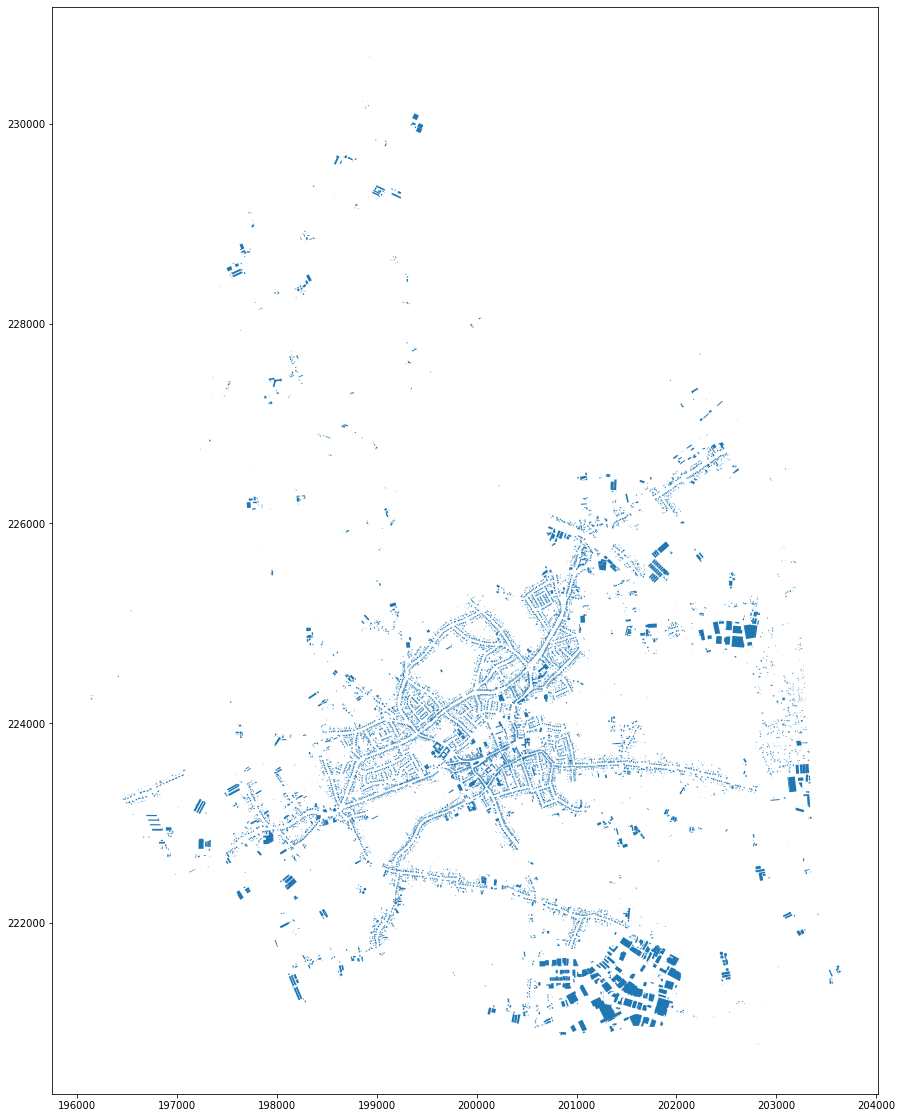

In [5]:
Arendonk=gpd.read_file("../api/src/data/Cadastre_vlaanderen/Anvers/ARENDONK_L72_2019/Bpn_ReBu.shp")
fig, ax = plt.subplots(figsize=(20,20))
Arendonk.plot(ax=ax)

(223500.0, 224000.0)

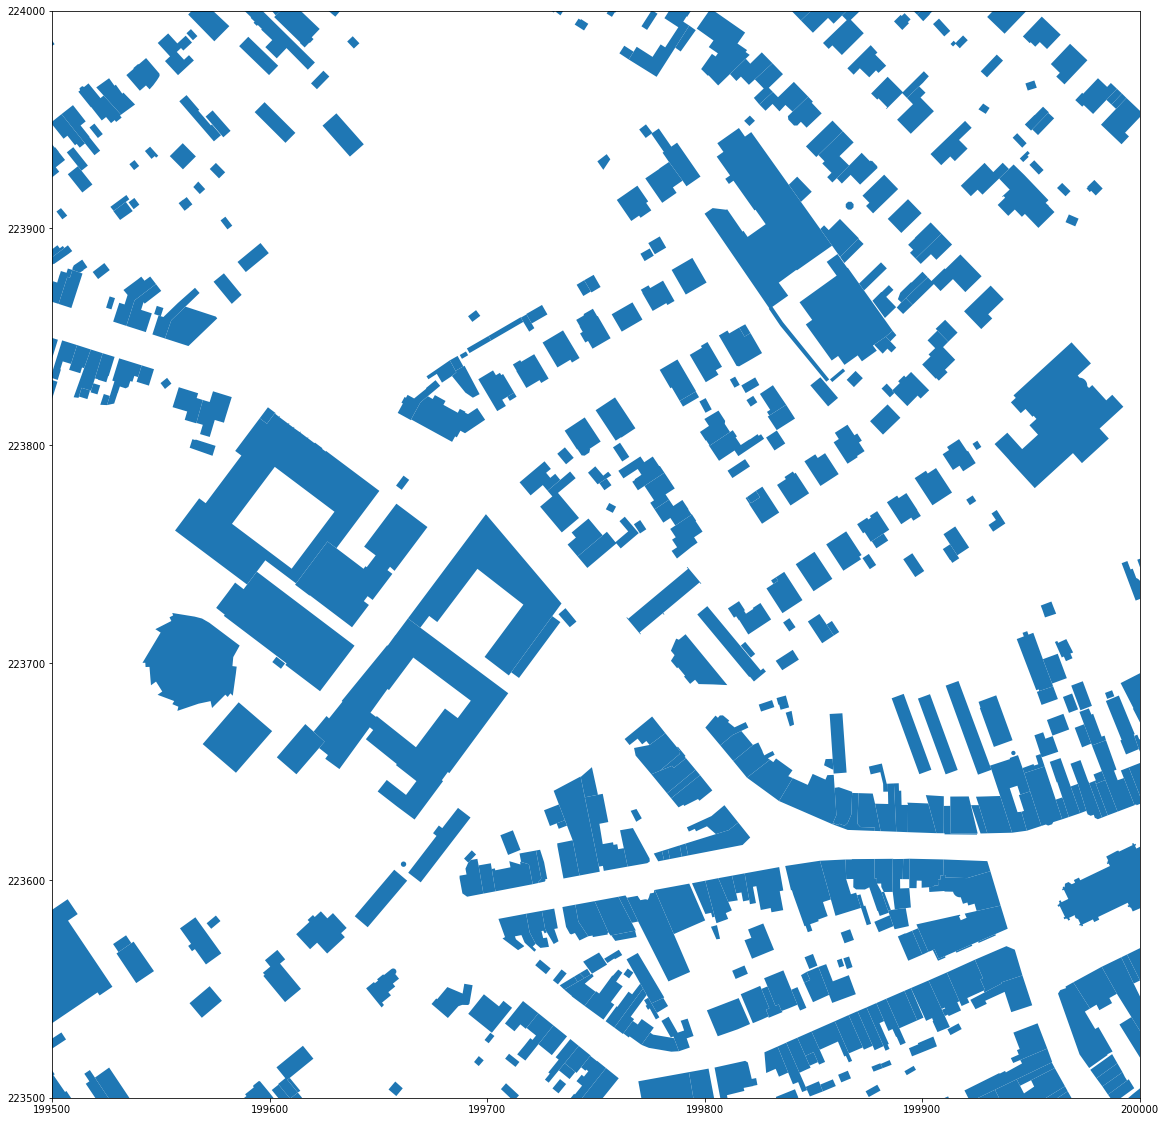

In [7]:
Arendonk_cadastre_ind=gpd.read_file("../api/src/data/Cadastre_vlaanderen/Anvers/ARENDONK_L72_2019/Bpn_ReBu.shp")
fig, ax = plt.subplots(figsize=(20,20))
Arendonk_cadastre_ind.plot(ax=ax)
ax.set_xlim([199500, 200000])
ax.set_ylim([223500, 224000])

In [38]:
# Arendonk_cadastre_ind

In [9]:
Arendonk_cadastre_ind.crs

{'proj': 'lcc',
 'lat_0': 90,
 'lon_0': 4.36748666666667,
 'lat_1': 49.8333339,
 'lat_2': 51.1666672333333,
 'x_0': 150000.01256,
 'y_0': 5400088.4378,
 'ellps': 'intl',
 'units': 'm',
 'no_defs': True}

In [10]:
Arendonk_cadastre_ind.bounds

,minx,miny,maxx,maxy
0,201072.426957,220894.925054,201077.199971,220898.414946
1,196812.467100,223320.602187,196820.443122,223326.754058
2,198291.967703,222863.499149,198298.564648,222870.085949
3,199259.985040,223513.900116,199270.658273,223526.991056
4,199279.752820,223505.670226,199287.461959,223514.786127
...,...,...,...,...
14109,198712.175173,224461.600568,198713.625857,224463.052187
14110,198713.601415,224460.246911,198715.000806,224461.643816
14111,202824.148095,225015.014065,202825.477300,225016.341666
14112,200261.393182,224405.025533,200262.341084,224405.974136


#### city global cadastral map --> shapefile.Reader @shp

In [12]:
Arendonk_cadastre_glob = shapefile.Reader("../api/src/data/Cadastre_vlaanderen/Anvers/ARENDONK_L72_2019/Bpn_ReBu.shp")

In [13]:
Arendonk_cadastre_glob.bbox

[196127.5765204133, 220782.2046619635, 203647.32441024092, 230679.30795220565]

In [14]:
Arendonk_cadastre_glob.shapeType

5

In [15]:
Arendonk_cadastre_glob.shapeTypeName

'POLYGON'

In [16]:
len(Arendonk_cadastre_glob)

14114

In [18]:
#Arendonk_cadastre_glob.shapes()

#### open and plot global lidar geotif file

In [19]:
with rio.open('../api/src/data/DSM_vlaanderen/DHMVIIDSMRAS1m_k09/GeoTIFF/DHMVIIDSMRAS1m_k09.tif') as srcA:
        fl9_tif_im = srcA.read(1, masked=True)
        fl9_tif_ext = rio.plot.plotting_extent(srcA)  # srcA.bounds
        fl9_tif_profile = srcA.profile
        fl9_tif_shape = srcA.shape
        fl9_tif_crs = srcA.crs  

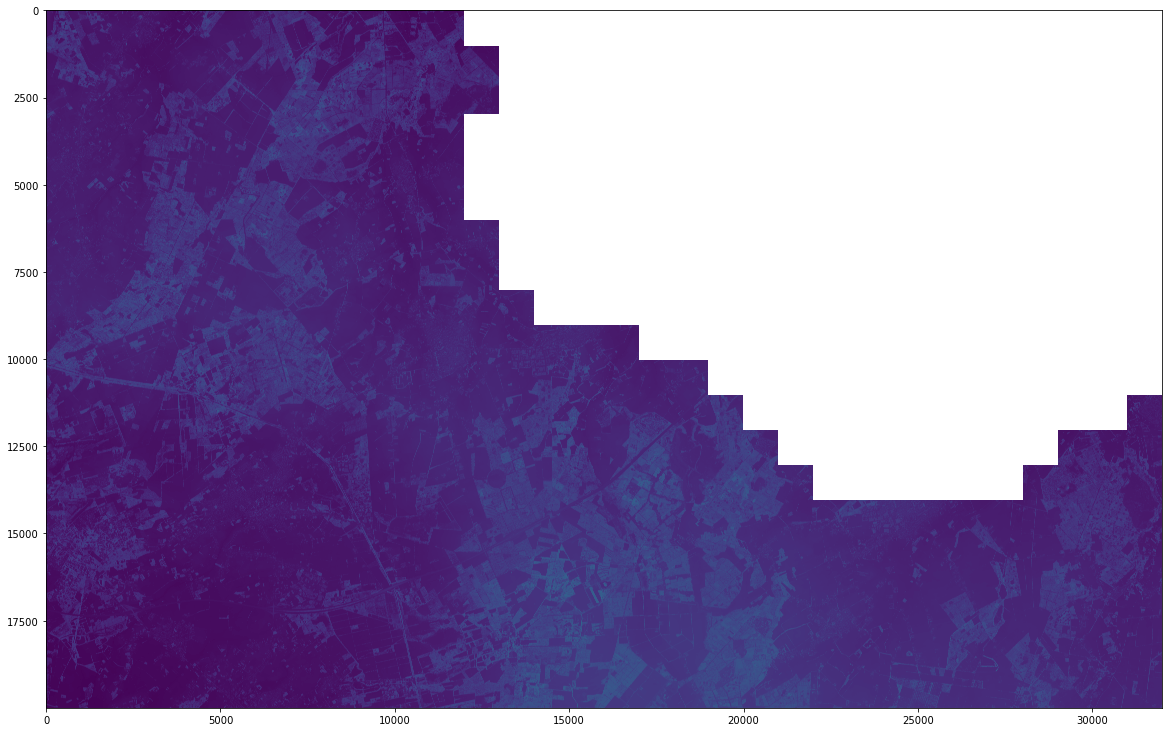

<AxesSubplot:>

In [20]:
fig, ax = plt.subplots(figsize=(20,20))
show(fl9_tif_im)

In [21]:
fl9_tif_im.shape

(20000, 32000)

In [22]:
fl9_tif_ext


(194000.0, 226000.0, 218000.0, 238000.0)

#### various ways to crop : buffer, cadaster .shp file geometry, window/slicing,...

In [23]:
from shapely.geometry import Point
test = Point(138221.16,149122.99)
# buffer with CAP_STYLE = 3
buf = test.buffer(2000, cap_style=3)

In [24]:
with fiona.open("../api/src/data/Cadastre_vlaanderen/Anvers/ARENDONK_L72_2019/Bpn_ReBu.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [25]:
with rasterio.open('../api/src/data/DSM_vlaanderen/DHMVIIDSMRAS1m_k09/GeoTIFF/DHMVIIDSMRAS1m_k09.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

In [26]:
with rasterio.open('../api/src/data/DSM_vlaanderen/DHMVIIDSMRAS1m_k09/GeoTIFF/DHMVIIDSMRAS1m_k09.tif') as dsm :
    small_dsm = dsm.read(1, window=Window(0, 0, 512, 256), masked=True)


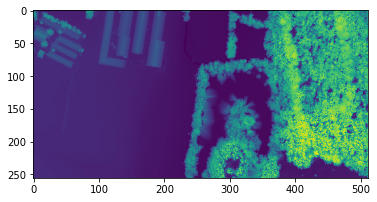

<AxesSubplot:>

In [27]:
show(small_dsm)

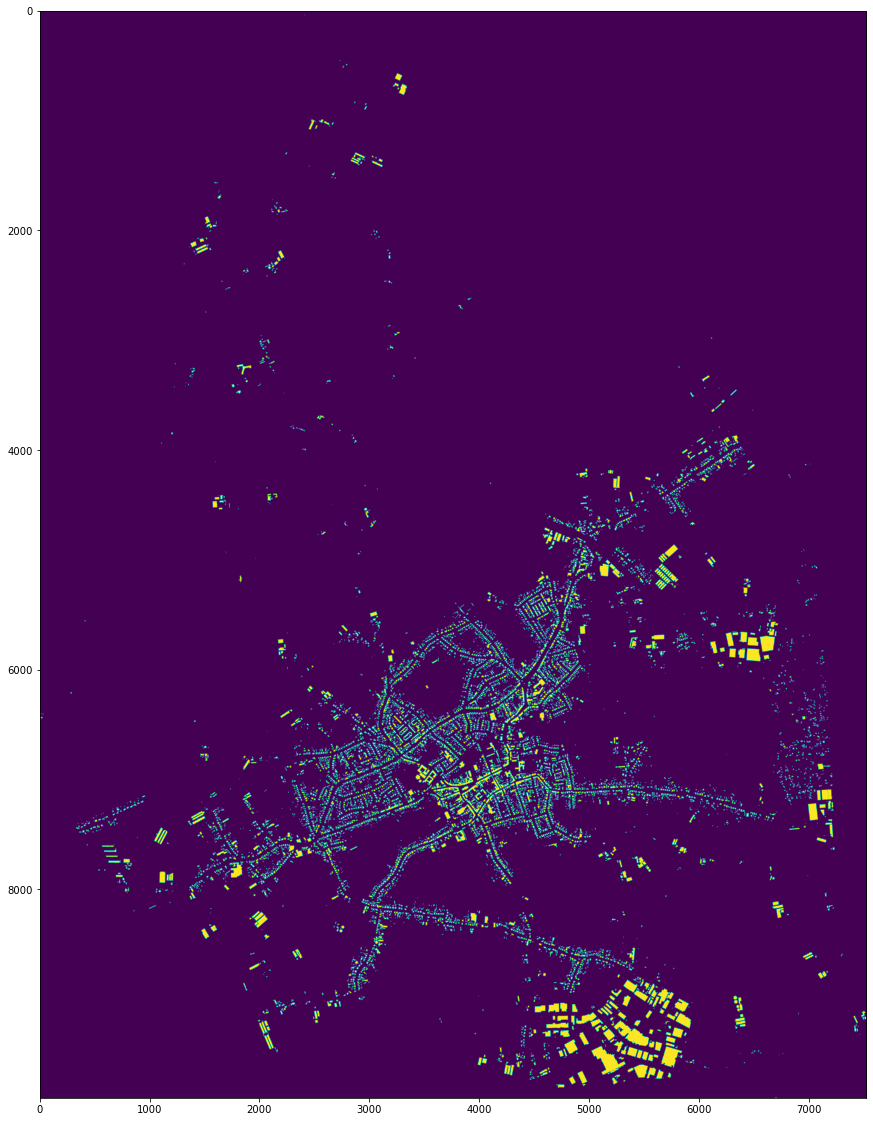

<AxesSubplot:>

In [28]:
fig, ax = plt.subplots(figsize=(20,20))
show(out_image)

In [30]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

In [46]:
# with rio.open("../api/src/data/output/Arendonk_cad_DSM.tif", "w", **out_meta) as dest:
#     dest.write(out_image)

In [33]:
from shapely.geometry import Point
test = Point(154875,244900)
buf = test.buffer(20, cap_style=3)

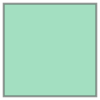

In [34]:
buf

Crop Arendonk

In [36]:
# fl9_file = '../api/src/data/DSM_vlaanderen/DHMVIIDSMRAS1m_k09/GeoTIFF/DHMVIIDSMRAS1m_k09.tif'
# Arendonk_vect = gpd.read_file("../api/src/data/Cadastre_vlaanderen/Anvers/ARENDONK_L72_2019/Bpn_ReBu.shp")
# Arendonk_cadastre_glob = shapefile.Reader("../api/src/data/Cadastre_vlaanderen/Anvers/ARENDONK_L72_2019/Bpn_ReBu.shp")

In [37]:
# Arendonk_vect

In [79]:
Arendonk_cadastre_glob.bbox

[196127.5765204133, 220782.2046619635, 203647.32441024092, 230679.30795220565]

In [71]:
from shapely import geometry
poly = geometry.Polygon([[199191.41164528765, 223404.05530746654], [199191.41164528765, 223445.5467352746], [199229.574205367, 223445.5467352746], [199229.574205367, 223404.05530746654]])


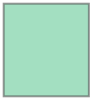

In [72]:
poly

In [36]:
fl9_tif_ext

(194000.0, 226000.0, 218000.0, 238000.0)

In [75]:
fl9_tif_crs

CRS.from_epsg(31370)

In [38]:
Arendonk_vect.crs

{'proj': 'lcc',
 'lat_0': 90,
 'lon_0': 4.36748666666667,
 'lat_1': 49.8333339,
 'lat_2': 51.1666672333333,
 'x_0': 150000.01256,
 'y_0': 5400088.4378,
 'ellps': 'intl',
 'units': 'm',
 'no_defs': True}

In [39]:
Arendonk_vect.bounds

,minx,miny,maxx,maxy
0,199197.892502,223425.240922,199211.034560,223434.280878
1,199191.411645,223427.390867,199209.503677,223445.546735
2,199220.905220,223405.705203,199229.574205,223416.387497
3,199218.334746,223404.055307,199226.061167,223414.273487


In [110]:
with rasterio.open(fl9_file) as Fsrc:    
    out_image, out_transform = rasterio.mask.mask(Fsrc,Arendonk_vect.geometry[1000:1020], crop=True, filled=False)
    Arendonk_profile = Fsrc.profile
    Arendonk_profile.update({"height": out_image.shape[1],
                              "width": out_image.shape[2],
                              "transform": out_transform})  


In [112]:
essai = out_image[:,500:1000,500:1000]

In [95]:
with rasterio.open(fl9_file) as Fsrc:    
    out_image2, out_transform = rasterio.mask.mask(Fsrc,[poly2], crop=True, filled=False)
    Arendonk_profile = Fsrc.profile
    Arendonk_profile.update({"height": out_image.shape[1],
                              "width": out_image.shape[2],
                              "transform": out_transform})  


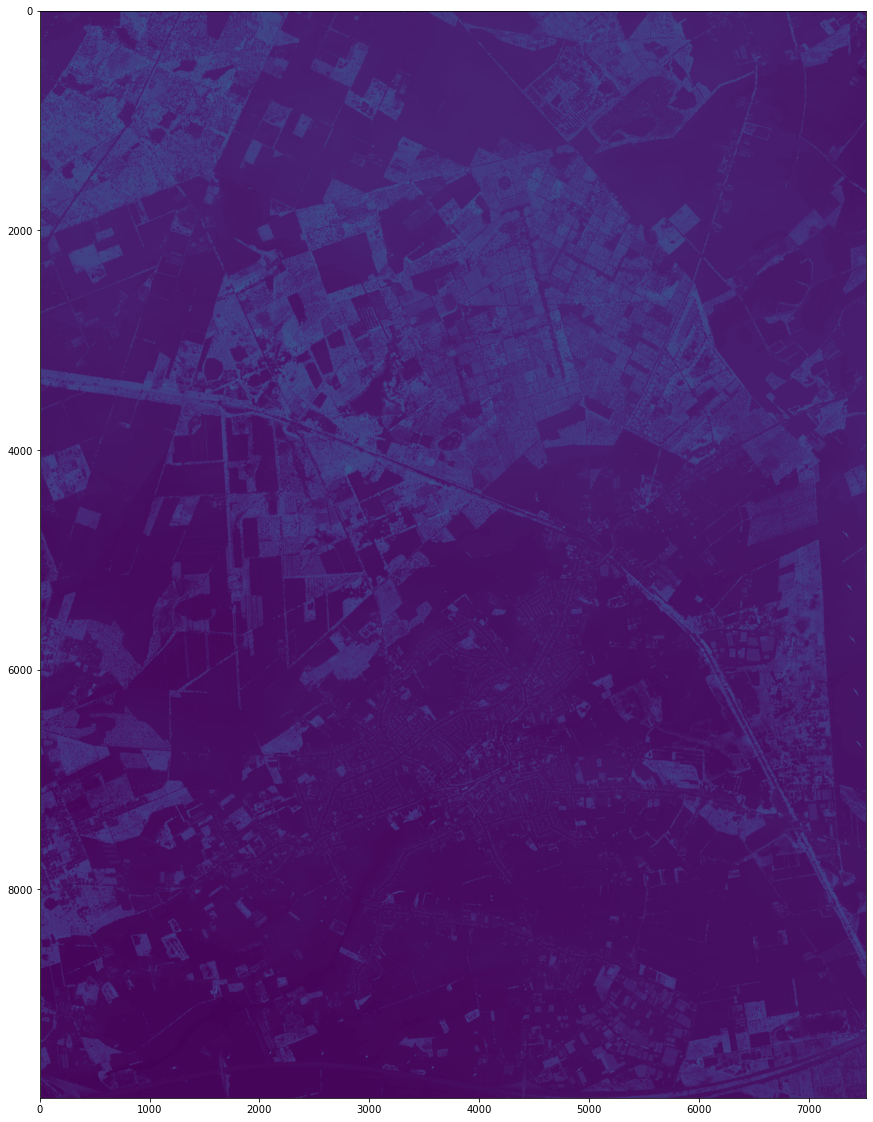

In [96]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(out_image2.squeeze())
